In [ ]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

DATA_PATH = 'D:/projects/bbeojung.kr/Data/final_dataset'

In [401]:
train = pd.read_parquet(os.path.join(DATA_PATH, 'train_2000.parquet'))
test = pd.read_parquet(os.path.join(DATA_PATH, 'test_2000.parquet'))

In [391]:
cols = ['bstop', 'bus', 'month', 'weekday', 'how', 'when', 
           'bstop_bus',
         'bstop_month', 
        'bstop_weekday', 
        'bstop_when',  
       'bus_month',   'bus_weekday',
         'bus_when', 
        'month_weekday', 
        'month_when',  
       'weekday_when',  
       'bstop_bus_month',  
       'bstop_bus_weekday',  
       'bstop_bus_when',  
       'bstop_month_weekday', 
        'bstop_month_when', 
        'bstop_weekday_when', 
        'bus_month_weekday', 
        'bus_month_when', 
        'bus_weekday_when', 
        'month_weekday_when', 
        'bstop_bus_month_weekday',
       'bstop_bus_month_when', 
        'bstop_bus_weekday_when',
       'bstop_month_weekday_when', 
        'bus_month_weekday_when',
       'bstop_bus_month_weekday_when']
num_col = list(set(train.columns) - set(cols))

train_df = train[num_col]
test_df = test[num_col].fillna(0)

In [409]:
train_df = train_df[['mean_bstop_bus_month_weekday', 'num']]
test_df = test_df[['mean_bstop_bus_month_weekday', 'num']]

In [417]:
def split_xy(df):
    return df[df.columns.difference(['num'])], df['num']

x_train, y_train = split_xy(train_df)
x_test, y_test = split_xy(test_df)    
train_col = x_train.columns
test_col = x_test.columns

In [393]:
scaler = StandardScaler()
scaler.fit(x_train)
train_res = scaler.transform(x_train)
test_res = scaler.transform(x_test)
x_train = pd.DataFrame(train_res, columns=train_col)
x_test = pd.DataFrame(test_res, columns=test_col)

In [394]:
# target(Price)와 가장 correlated 된 features 를 k개 고르기.
## selctor 정의하기.
selector = SelectKBest(score_func=f_regression, k=1)
## 학습데이터에 fit_transform 
x_train_selected = selector.fit_transform(x_train, y_train)
## 테스트 데이터는 transform
x_test_selected = selector.transform(x_test)
x_train_selected.shape, x_test_selected.shape

all_names = x_train.columns
## selector.get_support()
selected_mask = selector.get_support()
## 선택된 특성(변수)들
selected_names = all_names[selected_mask]
## 선택되지 않은 특성(변수)들
unselected_names = all_names[~selected_mask]

x_train_selected = pd.DataFrame(x_train_selected, columns=selected_names)
x_test_selected = pd.DataFrame(x_test_selected, columns=selected_names)

In [422]:
# By compare_model.ipynb
params = {
    'bagging_fraction' : 0.5,
    'bagging_freq' : 0,
    'boosting_type' : 'gbdt',
    'class_weight' : None,
    'colsample_bytree' : 1.0,
    'feature_fraction' : 0.9,
    'importance_type' : 'split',
    'learning_rate' : 0.2,
    'max_depth' : -1,
    'min_child_samples' : 76,
    'min_child_weight' : 0.001,
    'min_split_gain' : 0.5,
    'n_estimators' : 210,
    'n_jobs' : -1,
    'num_leaves' : 150,
    'objective' : None,
    'random_state' : 123,
    'reg_alpha' : 0.005,
    'reg_lambda' : 0.0005,
    'silent' : 'warn',
    'subsample' : 1.0,
    'subsample_for_bin' : 200000,
    'subsample_freq' : 0
}

In [423]:
lgbm = LGBMRegressor(**params)
lgbm.fit(x_train, y_train, eval_metric='mae')
y_pred = lgbm.predict(x_test)

MAE =  mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)

print(f'MAE : {MAE}', f'MSE : {MSE}', f'RMSE : {RMSE}', f'R2 : {R2}', sep='\n')

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
MAE : 3.3388308137461644
MSE : 59.26859836967434
RMSE : 7.698610158312625
R2 : 0.5390226661176656


In [396]:
# lgbm = LGBMRegressor(**params)
# lgbm.fit(x_train_selected, y_train, eval_metric='mae')
# y_pred = lgbm.predict(x_test_selected)

# MAE =  mean_absolute_error(y_test, y_pred)
# MSE = mean_squared_error(y_test, y_pred)
# RMSE = np.sqrt(MSE)
# R2 = r2_score(y_test, y_pred)

# print(f'MAE : {MAE}', f'MSE : {MSE}', f'RMSE : {RMSE}', f'R2 : {R2}', sep='\n')

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
MAE : 3.3386448868745293
MSE : 59.214667180328135
RMSE : 7.6951067036349885
R2 : 0.5394421303290993


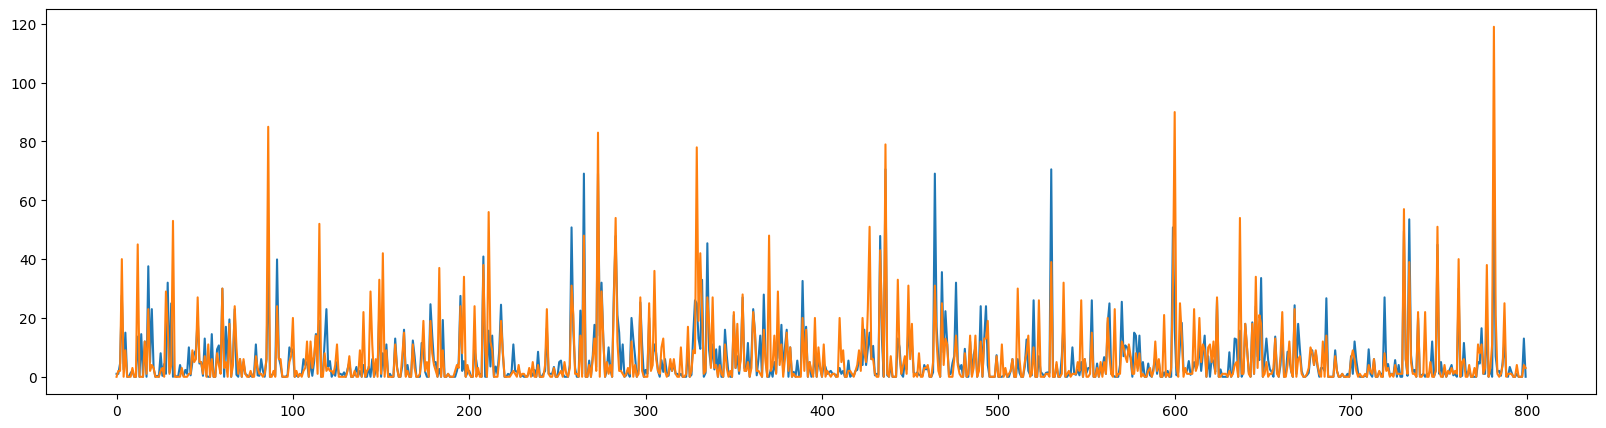

In [397]:
plt.figure(figsize=(20,5))
plt.plot(y_pred.tolist()[1500:2300])
plt.plot(y_test.tolist()[1500:2300])

In [424]:
lgbm.feature_importances_

array([2961])

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

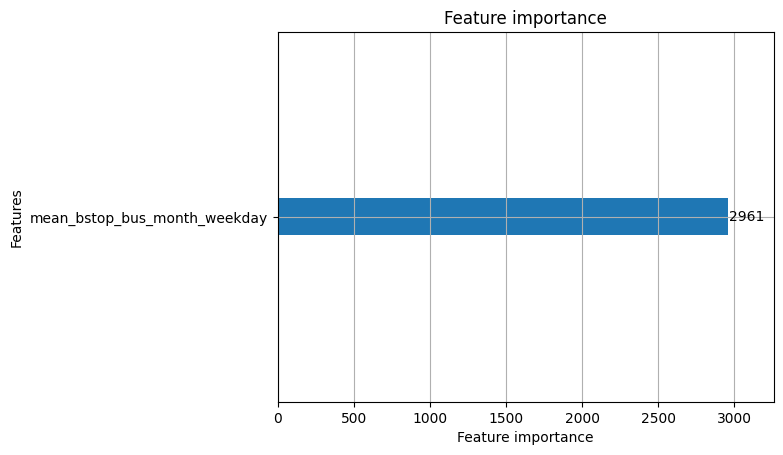

In [425]:
plot_importance(lgbm)

In [260]:
joblib.dump(lgbm, 'C:/Users/user/Desktop/bj/Bbeojung.kr/Web/Model/lgbm_third.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/user/Desktop/bj/Bbeojung.kr/Web/Model/lgbm_third.pkl'